In [8]:
%pip install torch
%pip install torchvision

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install --upgrade numpy



[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from PIL import Image,ImageOps
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io
import os

c:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pathToCategories = "./baseline/baseline/"
# labels=["highway", "office", "pedestrians", "PETS2006"]
# fonction d'acquisition des donnees dentrees et de validation pour l'analyse par rapport a une categories de video mis en parametre
def init_dataset(labels):
    input_data = {}
    groundTruth_data = {}
    nb_image = {}
    i=0
    for label in labels:
        input_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/input/").glob('*.jpg')]
        groundTruth_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/groundtruth/").glob('*.png')]
        nb_image[label] = len(input_data[label])
    return nb_image,input_data,groundTruth_data


In [3]:
def output_dataset(labels):
    output_data_sem_seg = {}
    output_data_vibe = {}
    nb_image = {}
    i=0
    for label in labels:
        output_data_sem_seg[label] = [str(p) for p in Path(
            pathToCategories+label+"/output_sem_seg/").glob('*.jpg')]
        output_data_vibe[label] = [str(p) for p in Path(
            pathToCategories+label+"/output_vibe/").glob('*.jpg')]
        #nb_image[label] = len(output_data_sem_seg[label])
    return output_data_sem_seg,output_data_vibe

In [5]:
nb_image,input_data,groundTruth_data=init_dataset(labels)

In [4]:
labels=["highway", "office", "pedestrians", "PETS2006"]
output_data_sem_seg,output_data_vibe=output_dataset(labels)

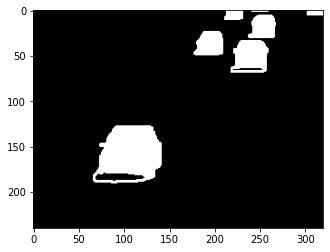

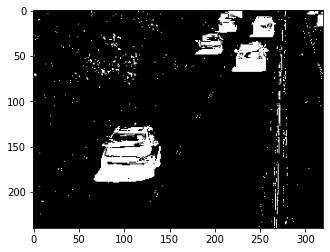

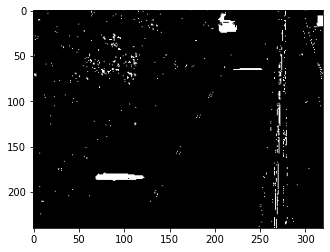

[  0 255]
[  0 255]


(array([-255.,    0.,  255.]), array([ 2096, 73025,  1679], dtype=int64))

In [31]:
im_out=io.imread(output_data_vibe["highway"][0])
im_g=io.imread(groundTruth_data["highway"][1000])
im_g[im_g>=170]=255
im_g[im_g<=50]=0
plt.imshow(im_g,cmap="gray")
plt.show()
plt.imshow(im_out,cmap="gray")
plt.show()
plt.imshow(abs(im_out-im_g),cmap="gray")
plt.show()
print(np.unique(im_g))
print(np.unique(im_out))
#print(np.unique(im_g-im_out,return_counts=True))
np.unique(im_out.astype(float)-im_g.astype(float),return_counts=True)

In [9]:
-im_out.astype(float)


(2, 3)

In [30]:
def PercentageCorrectClassification(img,groundtruth):
    res=np.unique(img.astype(float)-groundtruth.astype(float),return_counts=True)
    FN=res[1][0]
    TPandTN=res[1][1]
    FP=res[1][2]
    PCC=TPandTN/(TPandTN+FP+FN)
    return PCC

In [13]:
PercentageCorrectClassification(im_out,im_g)

0.9508463541666666

In [23]:
def classifactionMetrics(img,groundtruth):
    groundtruth_c=np.copy(groundtruth)
    groundtruth_c[groundtruth_c==0]=1 #pour pouvoir distinguer TN de TP
    res=np.unique(img.astype(float)-groundtruth_c.astype(float),return_counts=True)
    FN=res[1][0]
    TN=res[1][1]
    TP=res[1][2]
    FP=res[1][3]
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1_score=2*precision*recall/(precision+recall)
    return precision,recall,f1_score

In [60]:
tab=np.unique(res.astype(float)-groundtruth.astype(float),return_counts=True)

In [66]:
d=dict(zip(tab[0],tab[1]))
d[1]

KeyError: 1

In [57]:
len(groundtruth[groundtruth==])

0

In [69]:
count={0:0,1:0,255:0,-255:0}
count

{0: 0, 1: 0, 255: 0, -255: 0}

In [73]:
def jaccardCoeff(img,groundtruth,positiveClass="foreground"):
    groundtruth_c=np.copy(groundtruth)
    groundtruth_c[groundtruth_c==0]=1 #pour pouvoir distinguer TN de TP
    res=np.unique(img.astype(float)-groundtruth_c.astype(float),return_counts=True)
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    if positiveClass=="foreground":
        coeff=TP/(TP+FP+FN)
    else:
        print("rutabage")
        coeff=TN/(TN+FP+FN)
    return coeff

In [54]:
classifactionMetrics(im_out,im_g)

(0.7261011419249592, 0.6798533679547885, 0.7022166127632721)

### Segmentation sémantique

In [ ]:
#fonction appliquant des pretransformation aux cathegories dimage recu et retournant la liste des images retransforme en Tensor

preprocessing = transforms.Compose([
    transforms.ToTensor(),
])
# def get_input_tensor(labels,input_data):
#     input_tensor_label = {}
#     for label in labels:
#         input_tensor_label[label] = []
#         for input in input_data[label]:
#             tensor = preprocessing(Image.fromarray(io.imread(input)))#io.imread(os.path.join(input)) )
#             #tensor = preprocessing(cv2.imread("./"+input))
#             input_tensor_label[label].append(tensor)
#     return input_tensor_label
def get_input_tensor(input_data):
    input_tensor_label = {}
    input_tensor_label = []
    for input in input_data:
        tensor = preprocessing(Image.fromarray(io.imread(input)))#io.imread(os.path.join(input)) )
            #tensor = preprocessing(cv2.imread("./"+input))
        input_tensor_label.append(tensor)
    return input_tensor_label

In [ ]:
input_tensor_label=get_input_tensor(labels,input_data)

KeyboardInterrupt: 

In [ ]:
# return images in batch for prediction analysist
#def stack_input_tensor(labels,input_tensor_label):
    #input_batch_tensor_label = {}
    #for label in labels:
        #input_batch_tensor_label[label] =[]
        #for tensor in input_tensor_label[label]:
        #input_batch_tensor_label[label]=torch.stack(input_tensor_label[label], 0)
        #input_batch_tensor_label=torch.stack(input_tensor_label, 0)
        #input_batch_tensor_label[label] = input_batch_tensor_label[label].cuda() 
    #return input_batch_tensor_label

def stack_input_tensor(input_tensor_label):
    input_batch_tensor_label=torch.stack(input_tensor_label, 0)
    return input_batch_tensor_label


In [ ]:
def evaluate(input_batch_tensor_label):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    predictions = {}
    with torch.no_grad():
        predictions = model(input_batch_tensor_label)
    return predictions

In [ ]:
def draw_segmentation_mask(image,nb_class):
  name_colors=list(mcolors.CSS4_COLORS.keys())[7+1:7+nb_class]
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  COLORS = np.vstack([[0, 0, 0], rgb_colors]).astype("uint8")
  COLORS[15] = [255,255,255] #class pour lidentification de personnes
  image.putpalette(COLORS)
  return image

#### Fonction Main de lexecution pour obtenir la segmentation sementique

In [ ]:
labels = ["highway"]# "office", "pedestrians", "PETS2006"]
batchSize = 4
print("initialising dataset: ",labels," with batchSize = ",batchSize)
nb_image, input_data, true_data = init_dataset(labels)
mini_input_data={}
for label in labels:
    print("current label :",label)
    current = 0
    anounce_ID =250
    while(current < nb_image[label]):
        if current > anounce_ID:
            print("are now at", anounce_ID)
            anounce_ID +=250
        if (current+batchSize) > nb_image[label]:
            mini_input_data[label]=input_data[label][current:-1]
            current = nb_image[label]
        else:
            mini_input_data[label]=input_data[label][current:(current+batchSize)]
            current += batchSize

        input_tensor_label = get_input_tensor(mini_input_data[label])
        input_batch_tensor_label = stack_input_tensor(input_tensor_label)
        predictions = evaluate(input_batch_tensor_label)
        nb_class = predictions['out'].shape[1]
        for i in range(len(mini_input_data[label])):
            prediction = torch.argmax(predictions['out'][i].squeeze(), dim=0).detach().cpu().numpy().astype(np.uint8)
            masks = Image.fromarray(prediction)
            segmentation_mask=draw_segmentation_mask(masks,nb_class)
            segmentation_mask = ImageOps.grayscale(segmentation_mask)
            segmentation_mask.save(mini_input_data[label][i].replace("input","output_sem_seg"),format="PNG")




initialising dataset:  ['highway']  with batchSize =  4
current label : highway
are now at 250
are now at 500
are now at 750
are now at 1000
are now at 1250
are now at 1500


### Soustraction d'arrière-plan

In [6]:
from random import randrange
import random
def initBackground(frame,nb_samples,gray_scale=False):
    frame_size=np.shape(frame)
    if gray_scale:
        background=np.empty((frame_size[0],frame_size[1],nb_samples))    
    else:
        background=np.empty((frame_size[0],frame_size[1],nb_samples,3))
    
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            if i<frame_size[0]-1 and j<frame_size[1]-1:
                if i>=1 and j>=1:
                    neighbours=frame[i-1:i+2,j-1:j+2]
                    
                    
                    #neighbours_pixel=np.delete(neighbours,(12,13,14))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        #neigh_pixel_index=randrange(np.shape(neighbours)[0]*np.shape(neighbours)[1]-1)
                        #background[i,j,k,0]=neighbours_pixel[neigh_pixel_index*3]
                        #background[i,j,k,1]=neighbours_pixel[neigh_pixel_index*3+1]
                        #background[i,j,k,2]=neighbours_pixel[neigh_pixel_index*3+2]
                        background[i,j,k]=frame[i_n,j_n]
                        
                elif i>=1:
                    neighbours=frame[i-1:i+2,j:j+2]
                    #neighbours_pixel=np.delete(neighbours,(6,7,8))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                elif j>=1:
                    neighbours=frame[i:i+2,j-1:j+2]
                    #neighbours_pixel=np.delete(neighbours,(3,4,5))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                else:
                    neighbours=frame[i:i+2,j:j+2]
                    #neighbours_pixel=np.delete(neighbours,(0,1,2))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([          [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            elif i<frame_size[0]-1:
                if i>=1:
                    neighbours=frame[i-1:i+2,j-1:j+1]
                    #neighbours_pixel=np.delete(neighbours,(9,10,11))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j],])
                        background[i,j,k]=frame[i_n,j_n]
                else:
                    neighbours=frame[i:i+2,j-1:j+1]
                    #neighbours_pixel=np.delete(neighbours,(9,10,11))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1], 
                                                  [i+1, j-1], [i+1, j]])
                        background[i,j,k]=frame[i_n,j_n]
            elif j<frame_size[1]-1:
                if j>=1:
                    neighbours=frame[i-1:i+1,j-1:j+2]
                    #neighbours_pixel=np.delete(neighbours,(12,13,14))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                else:
                    neighbours=frame[i-1:i+1,j:j+2]
                    #neighbours_pixel=np.delete(neighbours,(6,7,8))
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            else:
                neighbours=frame[i-1:i+1,j-1:j+1]
                #neighbours_pixel=np.delete(neighbours,(9,10,11))
                for k in range(nb_samples):
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])
                    background[i,j,k]=frame[i_n,j_n]

    return background      




In [15]:
import random
def updateBackground(background, frame):
    frame_size = np.shape(frame)
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            update = randrange(16)
            if update == 15:
                sample = randrange(20)
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        #neighbours = frame[i-1:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                        #i_padding = randrange(-1, 2)
                        #i_padding += i_padding >= 0
                        #j_padding = randrange(-1, 2)
                        #j_padding += j_padding >= 0 and i_padding >= 0

                    elif i >= 1:
                        neighbours = frame[i-1:i+2, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        """
                        i_padding = randrange(-1, 2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    elif j >= 1:
                        neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        """
                        i_padding = randrange(2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    else:
                        neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        """
                        i_padding = randrange(2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                elif i < frame_size[0]-1:
                    if i >= 1:
                        neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        """
                        i_padding = randrange(-1, 2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 1)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    else:
                        neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        """
                        i_padding = randrange(2)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 1)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                elif j < frame_size[1]-1:
                    if j >= 1:
                        neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        """
                        i_padding = randrange(-1, 1)
                        i_padding += i_padding >= 0
                        j_padding = randrange(-1, 2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                    else:
                        neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        """
                        i_padding = randrange(-1, 1)
                        i_padding += i_padding >= 0
                        j_padding = randrange(2)
                        j_padding += j_padding >= 0
                        background[i, j, sample,
                                   0] = frame[i+i_padding, j+j_padding][0]
                        background[i, j, sample,
                                   1] = frame[i+i_padding, j+j_padding][1]
                        background[i, j, sample,
                                   2] = frame[i+i_padding, j+j_padding][2]
                        """
                else:
                    neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])
                    """
                    i_padding = randrange(-1, 1)
                    i_padding += i_padding >= 0
                    j_padding = randrange(-1, 1)
                    j_padding += j_padding >= 0
                    background[i, j, sample,
                               0] = frame[i+i_padding, j+j_padding][0]
                    background[i, j, sample,
                               1] = frame[i+i_padding, j+j_padding][1]
                    background[i, j, sample,
                               2] = frame[i+i_padding, j+j_padding][2]
                    """
                background[i, j, sample,
                                   0] = frame[i_n, j_n][0]
                background[i, j, sample,
                            1] = frame[i_n, j_n][1]
                background[i, j, sample,
                            2] = frame[i_n, j_n][2]
                updateNeighbour(i_n, j_n,
                                i, j, background, frame)


In [ ]:
import random
i=2
j=19
i_n, j_n = random.choice([[i, j-1], [i, j+1],[i+1, j-1], [i+1, j], [i+1, j+1]])
print(i_n,j_n)

3 20


In [7]:
def updateNeighbour(X_n,Y_n,X,Y,background,frame,nb_samples):
    k=randrange(nb_samples)
    background[X_n,Y_n,k]=frame[X,Y]
    

In [8]:
labels=["highway", "office", "pedestrians", "PETS2006"]
nb_images,input_data,groundTruth_data=init_dataset(labels)

In [ ]:
def segmentationViBe(frame,background_model,R,seuil):
    frame_shape=np.shape(frame)
    res=np.empty((frame_shape[0],frame_shape[1]))
    R2=R**2
    for i in range(frame_shape[0]):
        for j in range(frame_shape[1]):
            center=frame[i,j]
            #print(center)
            count=0
            #print("xample")
            for sample in background_model[i,j]:
                #print(sample)
                dist_with_center=(np.linalg.norm(center-sample))**2
                if dist_with_center<R2:
                    count+=1
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255
    return res


In [ ]:
import cv2
img=io.imread(input_data["PETS2006"][0])
#img=cv2.resize(img,(200,100))
background=initBackground(img)
for input in input_data["PETS2006"][1:20]:
    img=io.imread(input)
    #img=cv2.resize(img,(200,100))
    updateBackground(background,img)
    res=segmentationViBe(img,background,20,2)
    plt.imshow(img)
    plt.show()
    plt.imshow(res,cmap='gray', vmin=0, vmax=255)
    plt.show()


In [18]:
def segmentationViBe2(frame,background_model,R,seuil,nb_samples):
    frame_size=np.shape(frame)
    res=np.empty((frame_size[0],frame_size[1]))
    R2=R**2
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            center=frame[i,j]
            count=0
            #print("xample")
            for sample in background_model[i,j]:
                dist_with_center=(np.linalg.norm(center-sample))**2
                if dist_with_center<R2:
                    count+=1
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255

            #update background    
            update = randrange(16)
            if update == 15:
                sample = randrange(nb_samples)
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    elif i >= 1:
                        #neighbours = frame[i-1:i+2, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])

                    elif j >= 1:
                        #neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    else:
                        #neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
               
                elif i < frame_size[0]-1:
                    if i >= 1:
                        #neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                    
                    else:
                        #neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        
                elif j < frame_size[1]-1:
                    if j >= 1:
                        #neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        
                    else:
                        #neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        
                else:
                    #neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])

                """    
                background[i, j, sample,
                                   0] = frame[i_n, j_n][0]
                background[i, j, sample,
                            1] = frame[i_n, j_n][1]
                background[i, j, sample,
                            2] = frame[i_n, j_n][2]
                """
                background[i, j, sample] = frame[i_n, j_n]
                updateNeighbour(i_n, j_n,
                                i, j, background, frame,nb_samples)
    return res


In [26]:
def segmentationViBe3(frame,background_model,R,seuil,nb_samples):
    frame_size=np.shape(frame)
    res=np.empty((frame_size[0],frame_size[1]))
    R2=R**2
    for i in range(0,frame_size[0]):
        res[i,0]=0
        res[i,frame_size[1]-1]=0
    for j in range(0,frame_size[1]):
        res[0,j]=0
        res[frame_size[0]-1,j]=0
    for i in range(1,frame_size[0]-1):
        for j in range(1,frame_size[1]-1):
            center=frame[i,j]
            count=0
            #print("xample")
            for sample in background_model[i,j]:
                dist_with_center=(np.linalg.norm(center-sample))**2
                if dist_with_center<R2:
                    count+=1
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255

            #update background    
            update = randrange(16)
            if update == 15:
                sample = randrange(nb_samples)
                i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                          [i, j-1],             [i, j+1],
                                          [i+1, j-1], [i+1, j], [i+1, j+1]])

                background[i, j, sample] = frame[i_n, j_n]
                updateNeighbour(i_n, j_n,
                                i, j, background, frame,nb_samples)
    return res


In [17]:
def segmentationViBe4(frame,background_model,R,seuil,nb_samples,random_subsampling):
    frame_size=np.shape(frame)
    res=np.empty((frame_size[0],frame_size[1]))
    #R2=R**2
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            center=frame[i,j]
            count=0
            #print("xample")
            for sample in background_model[i,j]:
                dist_with_center=(np.linalg.norm(center-sample))
                if dist_with_center<R:
                    count+=1
                if count>=seuil:
                    break
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255

            #update background    
            update = randrange(random_subsampling)
            if update == 0:
                sample = randrange(nb_samples)
                background[i, j, sample] = frame[i, j]
            update = randrange(random_subsampling)
            if update == 0:
                sample=randrange(nb_samples)   
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    elif i >= 1:
                        #neighbours = frame[i-1:i+2, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])

                    elif j >= 1:
                        #neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    else:
                        #neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
               
                elif i < frame_size[0]-1:
                    if i >= 1:
                        #neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                    
                    else:
                        #neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        
                elif j < frame_size[1]-1:
                    if j >= 1:
                        #neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        
                    else:
                        #neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        
                else:
                    #neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])

                
                
                background[i_n,j_n,sample]=frame[i,j]
    return res


In [17]:
for i in range(1,5):
    print(i)

1
2
3
4


In [63]:
randrange(3)

2

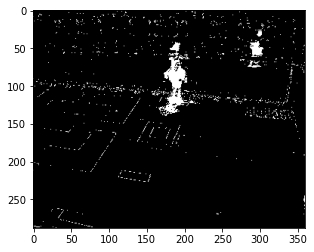

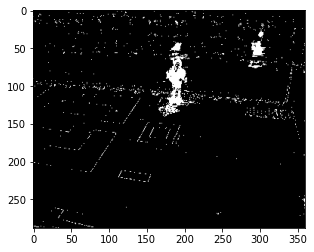

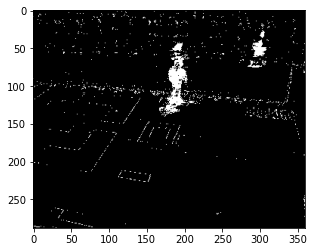

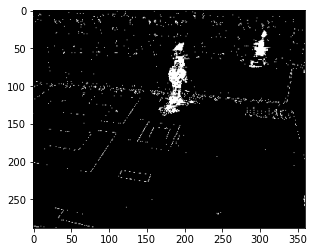

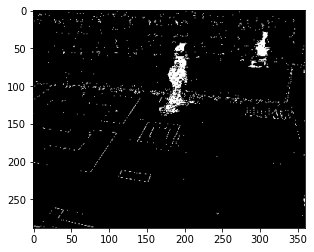

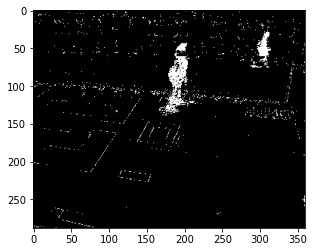

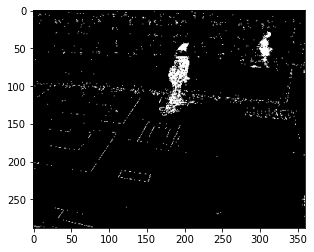

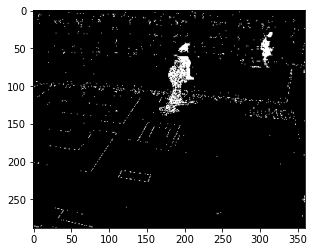

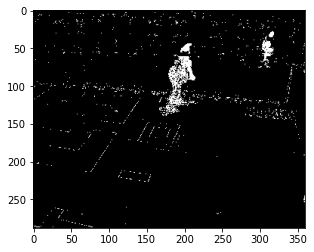

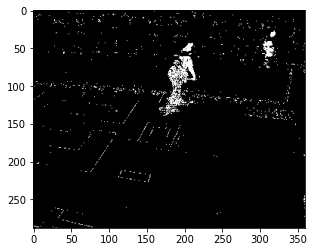

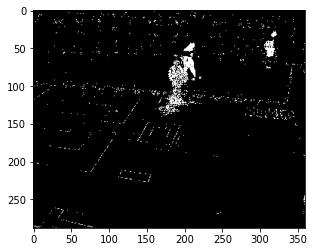

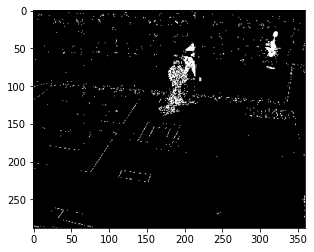

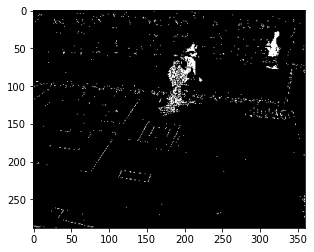

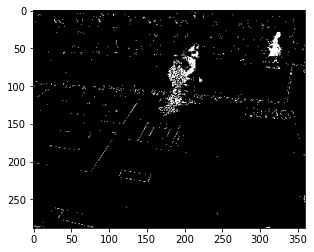

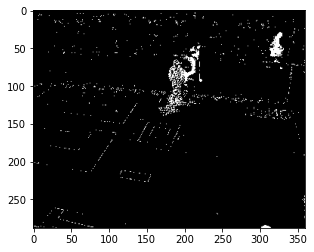

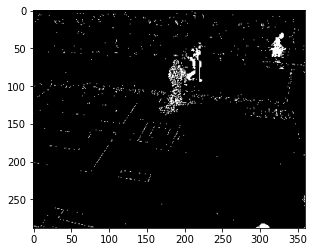

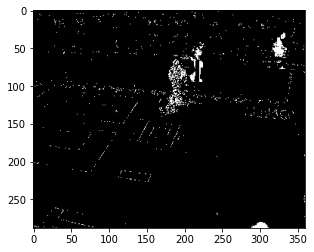

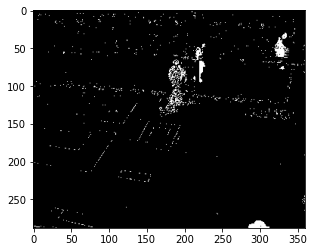

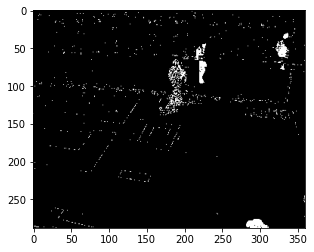

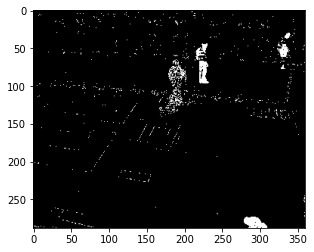

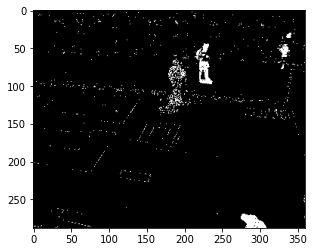

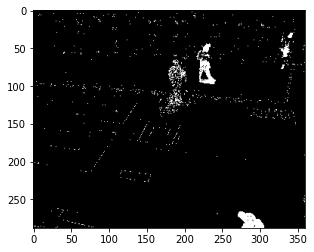

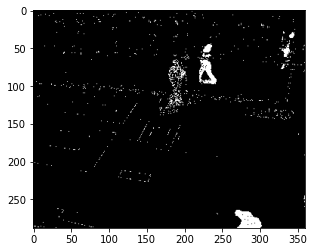

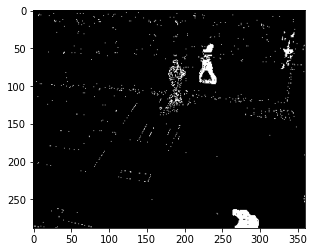

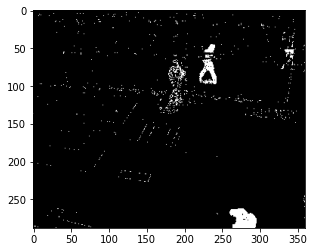

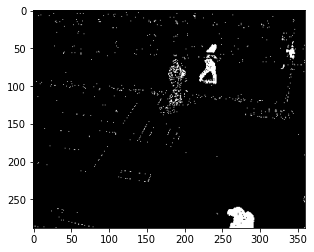

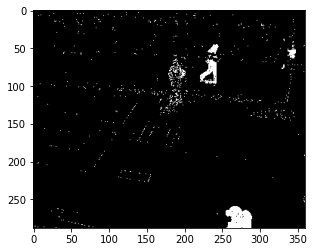

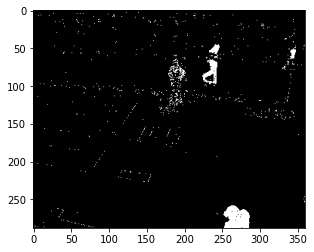

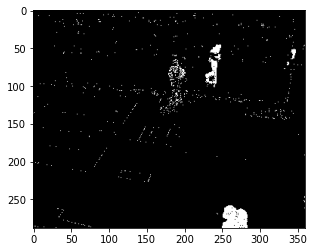

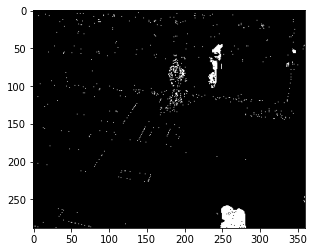

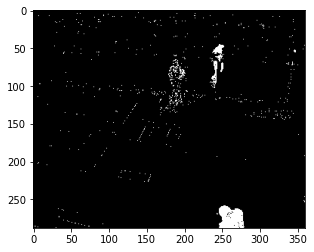

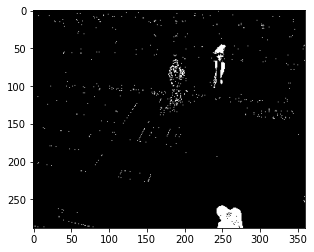

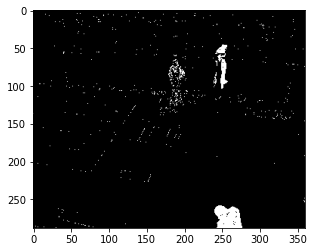

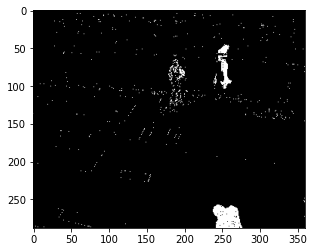

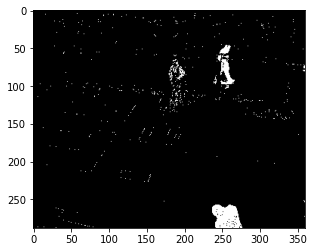

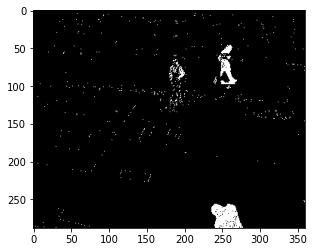

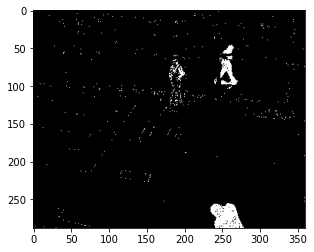

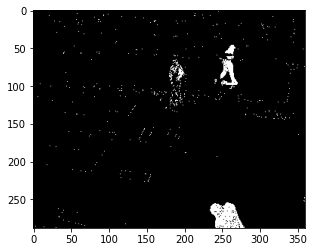

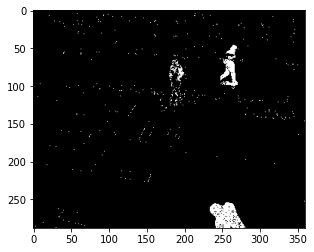

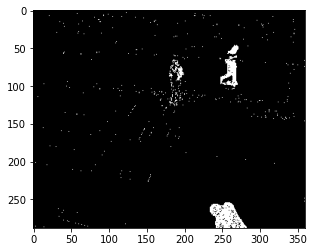

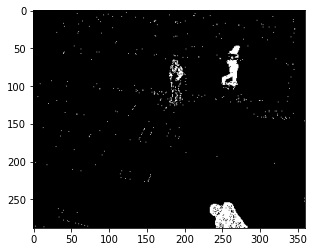

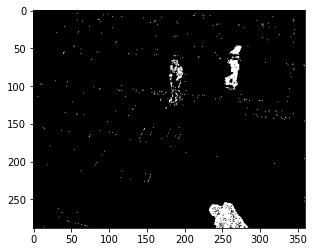

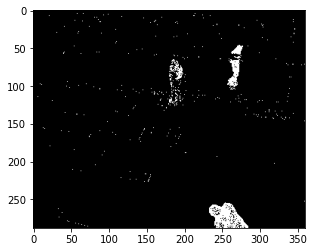

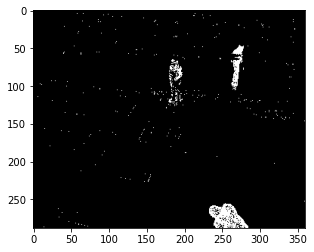

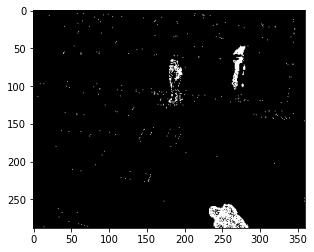

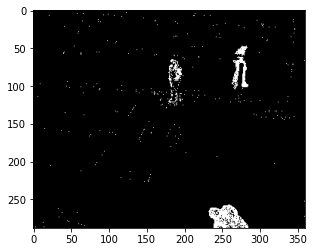

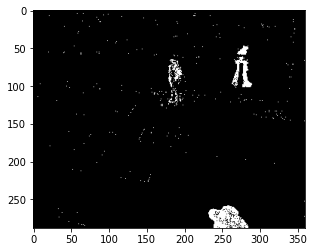

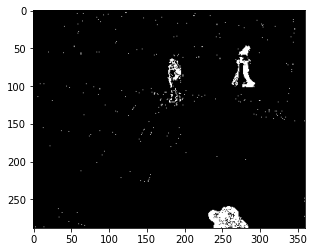

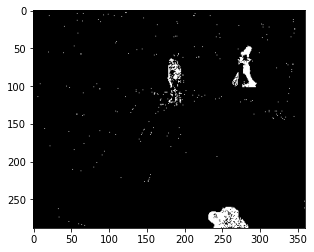

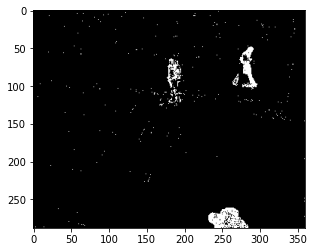

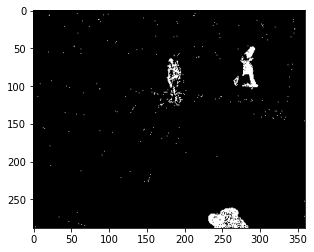

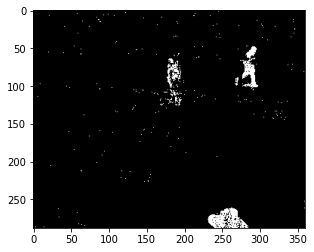

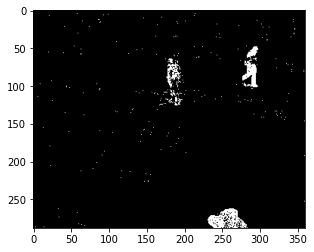

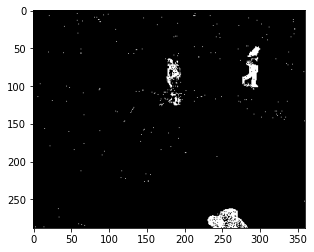

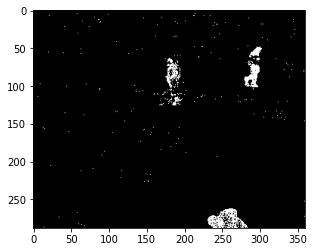

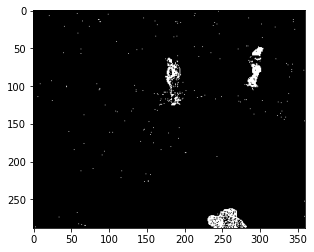

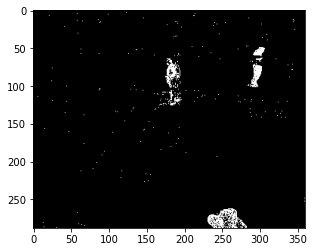

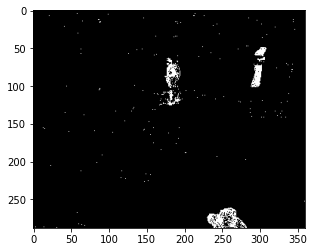

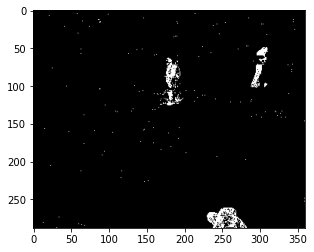

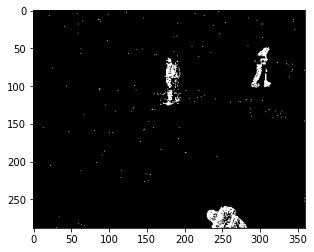

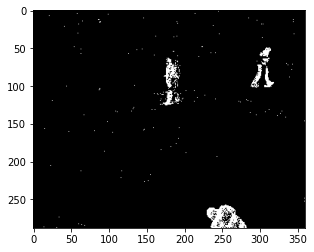

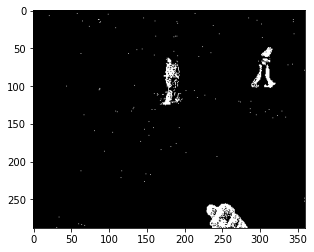

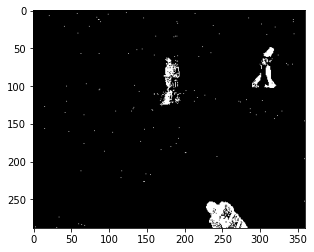

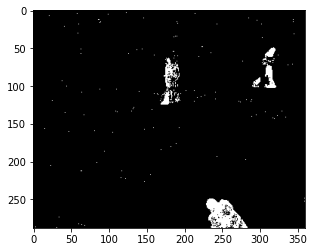

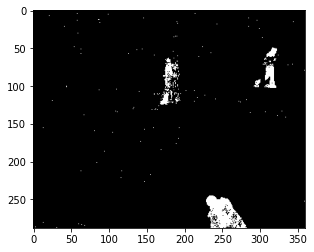

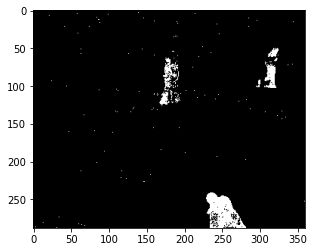

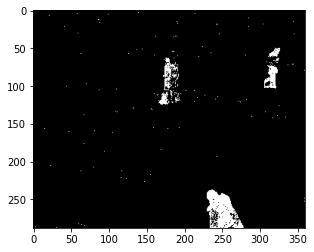

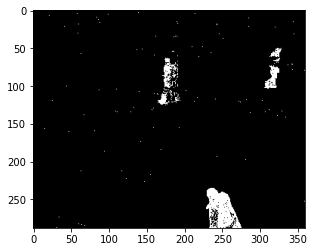

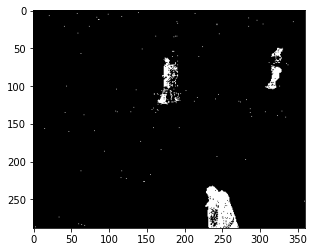

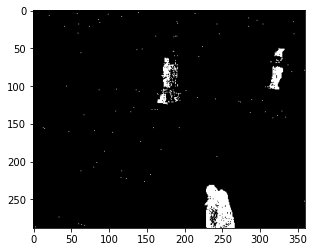

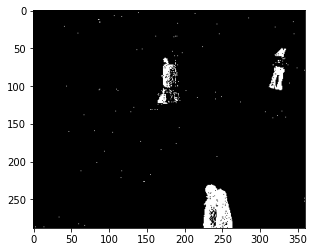

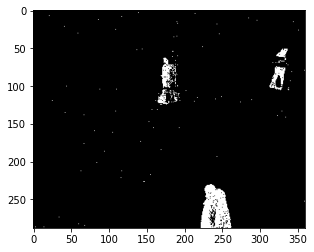

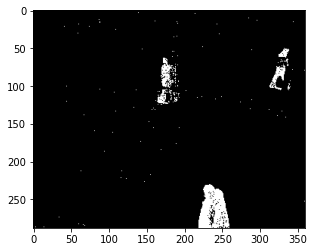

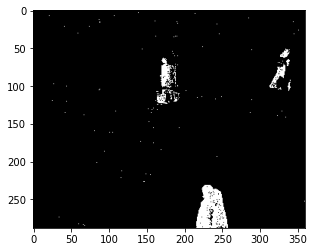

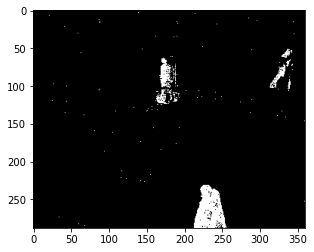

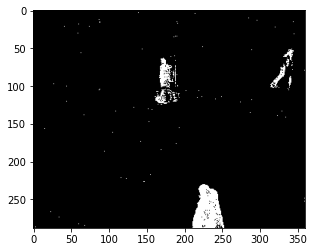

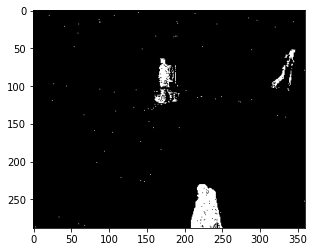

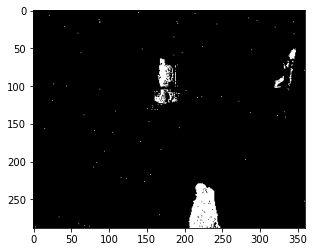

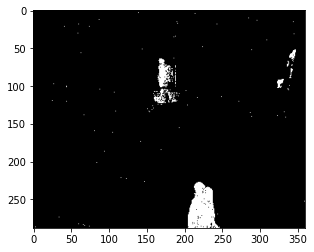

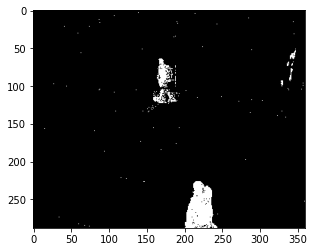

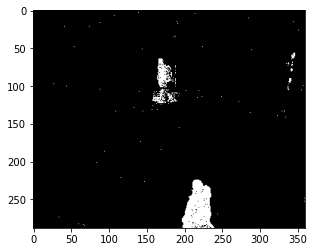

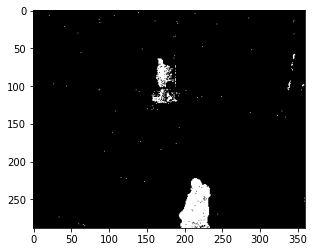

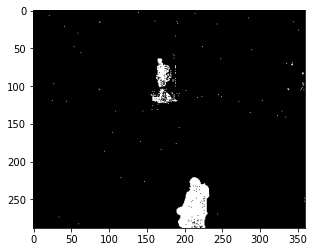

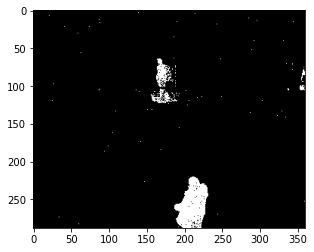

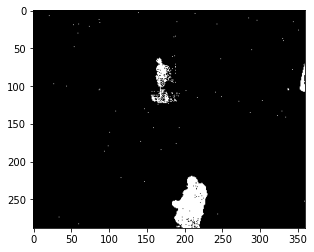

KeyboardInterrupt: 

In [20]:
import cv2
resize_relation=2

img=io.imread(input_data["PETS2006"][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data["PETS2006"][600:1100]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
    #Image.fromarray(res).convert('L').save(input.replace("input","output_vibe"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray')
    plt.show()


In [ ]:
import cv2
MOG=cv2.createBackgroundSubtractorMOG2(detectShadows=False)
MOG.setVarThreshold(16)

resize_relation=1

for input in input_data["pedestrians"][300:330]:
    img=io.imread(input)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=MOG.apply(img)
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray')
    plt.show()


In [ ]:
background[1,1]

array([[29., 37., 22.],
       [26., 34., 19.],
       [71., 79., 66.],
       [33., 41., 28.],
       [71., 79., 66.],
       [71., 79., 66.],
       [37., 45., 30.],
       [37., 45., 30.],
       [37., 45., 30.],
       [33., 41., 28.],
       [26., 34., 19.],
       [32., 40., 25.],
       [32., 40., 25.],
       [21., 29., 16.],
       [71., 79., 66.],
       [29., 37., 22.],
       [29., 37., 22.],
       [29., 37., 22.],
       [32., 40., 25.],
       [29., 37., 22.]])

In [ ]:
MOG.getVarThreshold()

16.0

In [ ]:
np.unique(res, return_counts=True)

(array([  0., 255.]), array([34435, 89315], dtype=int64))

#### Optimisation

In [27]:
def plot_hyperparameter_tuning(res,x_label_orientation="horizontal",x_axis_title="Hyper-parameter value"):
    """
    Montre le graph issu de la recherche d'hyperparamètres.

    Args:
        res: dictionnaire où pour une clé correspondant à la valeur donnée à l'hyperparamètre associe 
             le taux moyen d'images correctes obtenu avec ce dernier.
        x_label_orientation: orientation de label de l'axe horizontale ("vertical" ou "horizonal")
        x_axis_title: titre de l'axe des abscisses
    
    """
    plt.plot(res.keys(),res.values(),'-ro')
    keys_with_max=[key for key,value in res.items() if abs(value-max(res.values()))<1e-09]
    print("On obtient le taux de positivité maximal: "+str(max(res.values()))+"pour les valeurs d'hyperparamètre suivantes:\n"+str(keys_with_max))
    for key in keys_with_max:
        axv=plt.axvline(key, color="red", ls="--")
    if x_label_orientation=="vertical":
        plt.xticks(rotation=90)
    plt.ylabel("Taux de positivité")
    plt.xlabel(x_axis_title)
    axv.set_label("Meilleure configuration")
    plt.legend()
    plt.show()

In [32]:
import cv2

resize_relation=1
nb_samples=20

PCCs={}
res_to_plot={}


for value in [15,20,25,30,35,40,45]:
    PCCmoy=0
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        PCCs[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            PCCs[label].append(PercentageCorrectClassification(res,groundtruth))
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        PCCmoy+=np.mean(PCCs[label])
    PCCmoy=PCCmoy/len(labels)
    res_to_plot[value]=PCCmoy
    print("the mean PCC for hyperparameter value="+str(value)+" is "+str(PCCmoy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean PCC for hyperparameter value=15 is 0.729617185771932
the mean PCC for hyperparameter value=20 is 0.741466751657028
the mean PCC for hyperparameter value=25 is 0.7459668234514
the mean PCC for hyperparameter value=30 is 0.7478706055509412
the mean PCC for hyperparameter value=35 is 0.7487857057279134
the mean PCC for hyperparameter value=40 is 0.7490630664740873
the mean PCC for hyperparameter value=45 is 0.7486756416671377


In [25]:
f1_score_plot,precision,recall,f1_score={},{},{},{}
resize_relation=2

for value in [15,20,25,30,35,40]:
    f1_score_moy=0
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        precision[label]=[]
        recall[label]=[]
        f1_score[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            p,r,f=classifactionMetrics(res,groundtruth)
            precision[label].append(p)
            recall[label].append(r)
            f1_score[label].append(f)
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        f1_score_moy+=np.mean(f1_score[label])
    f1_score_moy=f1_score_moy/len(labels)
    f1_score_plot[value]=f1_score_moy
    print("the mean f1 score for hyperparameter value="+str(value)+" is "+str(f1_score_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean f1 score for hyperparameter value=15 is 0.46581772255413084
the mean f1 score for hyperparameter value=20 is 0.5271095179698017
the mean f1 score for hyperparameter value=25 is 0.5605654116207943
the mean f1 score for hyperparameter value=30 is 0.5762989646047191
the mean f1 score for hyperparameter value=35 is 0.5866919038394588
the mean f1 score for hyperparameter value=40 is 0.5850462468002917


In [35]:
jaccard_coeff={}
resize_relation=2

for value in [15,20,25,30,35,40,45]:
    coeff_moy=0
    coeff={}
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        coeff[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            coeff[label].append(jaccardCoeff(res,groundtruth))
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        coeff_moy+=np.mean(coeff[label])
    coeff_moy=coeff_moy/len(labels)
    jaccard_coeff[value]=coeff
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(coeff_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

the mean f1 score for hyperparameter value=15 is 0.3194812392135808
the mean f1 score for hyperparameter value=20 is 0.3798383186318722
the mean f1 score for hyperparameter value=25 is 0.4175609920948133
the mean f1 score for hyperparameter value=30 is 0.4396601418683033
the mean f1 score for hyperparameter value=35 is 0.44811155379607837
the mean f1 score for hyperparameter value=40 is 0.44968110403813355
the mean f1 score for hyperparameter value=45 is 0.4468122045312897


In [79]:
jaccard_coeff={}
resize_relation=2

for value in [15,20,25,30,35,40,45]:
    coeff_moy=0
    coeff={}
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        coeff[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,700):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
        for i in range(700,731):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            coeff[label].append(jaccardCoeff(res,groundtruth))
        print("the mean jaccard's coefficient for for label "+label+": "+str(np.mean(coeff[label])))
        coeff_moy+=np.mean(coeff[label])
    coeff_moy=coeff_moy/len(labels)
    jaccard_coeff[value]=coeff
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(coeff_moy))

KeyboardInterrupt: 

In [ ]:
precision,recall,f1_score={},{},{}
resize_relation=2

for value in [15,20,25,30,35,40]:
    f1_score_moy=0
    for label in labels:
        if label=="PETS2006":
            resize_relation=2
        else:
            resize_relation=1
        precision[label]=[]
        recall[label]=[]
        f1_score[label]=[]
        img=io.imread(input_data[label][0])#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        background=initBackground(img,nb_samples)#,gray_scale=True)
        for i in range(600,631):
            input=input_data[label][i]
            groundtruth=io.imread(groundTruth_data[label][i])
            groundtruth[groundtruth>=50]=255
            img=io.imread(input)#,as_gray=True)
            img_shape=np.shape(img)
            img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
            #res=segmentationViBe2(img,background,0.15,2,nb_samples)
            res=segmentationViBe4(img,background,value,2,nb_samples,16)
            p,r,f=classifactionMetrics(res,groundtruth)
            precision[label].append(p)
            recall[label].append(r)
            f1_score[label].append(f)
        #print("the mean PCC for label "+label+": "+str(np.mean(PCCs[label])))
        f1_score_moy+=np.mean(f1_score[label])
    f1_score_moy=f1_score_moy/len(labels)
    res[value]=f1_score_moy
    print("the mean f1 score for hyperparameter value="+str(value)+" is "+str(f1_score_moy))
        #plt.imshow(img,cmap='gray')
        #plt.show()
        #plt.imshow(res,cmap='gray')
        #plt.show()

In [39]:
moy=0
for label in labels:
    moy+=np.mean(PCCs[label])
    print(np.mean(PCCs[label]))
moy=moy/len(labels)
moy

0.9689322916666666
0.9608912037037036
0.9611910095579451
0.98269994835225


0.9684286133201414